Let's start with some basic import.

In [1]:
import findspark
import pyspark
import random

from contextlib import contextmanager
import logging
import pyarrow.parquet as pq
import time

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *

## Let's configure our Spark environment.
For simplicity, we will work in Spark in local settings and **you can do the same in your project**. 

You just need to run the following lines of code (local[*] stands for "use all the cores of your CPU").

That means you won't be able to use multiple machines, but you will be able to use the multi-processor capabilities of your CPU.

If you have the possibility to use multiple machines connected to the same local network (as we have done during one TP of the course) and you want to configure a Spark standalone (distributed) cluster with one master node and a certain number of worker nodes, please refer to the jupyter notebook named **03_From local to distributed**, which has been shared with you during one of the DSML2 class.


In [26]:
#remember to stop the context if you re-execute this cell multiple times:
#sc.stop()

spark = SparkSession.builder \
    .master("local[*]") \
    .appName('Clustering Lyon data') \
    .config("spark.network.timeout", "10000000") \
    .config("spark.driver.memory", "30g") \
    .getOrCreate() 

sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Clustering Lyon data>

## Let's load the Lyon trips data in parquet format

We are going to work on a Parquet file, containing the GPS observations for Lyon on the first week of October. 

The usage of Parquet files is optional for your Spark project. You can work with csv files as well in Spark (as you can see with the links_with_iris.csv file a bit below in this Jupyter notebook. However, as you know, working with Parquet is beneficial, as this structure is optimized in the Spark api, even in local settings.

Let's load the parquet files of Lyon.
Adapt to your configuration the filepaths to the folders containing the parquet data.

In [3]:
DATA_FOLDER_LYON_TRIPS = '/Volumes/LaCie/datasets/fcd_mediamobile_2017_2018/Parquet' #adapt the path to your case

### Let's read the trips data

We are going to measure the time it takes to perform the following operations in Spark, by using the time_usage function below. You can report the computed time information in your report and provide a comparison with the same measures performed on your pandas implementation.

Please refer to the jupyter notebook named **02_From Pandas to Pyspark**, which has been shared with you during the DSML2 class to remember how to measure time with the time_usage function on both Spark and Pandas operations.

In [4]:
logging.getLogger().setLevel(logging.INFO)

@contextmanager
def time_usage(name=""):
    """log the time usage in a code block
    prefix: the prefix text to show"""
    start = time.time()
    yield
    end = time.time()
    elapsed_seconds = float("%.4f" % (end - start))
    logging.info('%s: elapsed seconds: %s', name, elapsed_seconds)

In [5]:
#read the content of the parquet:
with time_usage("Reading parquet"):
    dfTrips = spark.read.parquet("file:///" + DATA_FOLDER_LYON_TRIPS)
dfTrips = dfTrips.withColumn("hour", hour(col("parsedTimestamp")))
dfTrips = dfTrips.withColumn("minute", minute(col("parsedTimestamp")))

#show the content of the first 10 lines of the dfTrips
#with time_usage("Showing the first 10 lines"):
#    dfTrips.show(10)

INFO:root:Reading parquet: elapsed seconds: 13.3058


The <code>printSchema()</code> method provides information on the dataframe, including the type associated to each column.

In [6]:
with time_usage("Printing schema"):
    dfTrips.printSchema()

INFO:root:Printing schema: elapsed seconds: 0.0078


root
 |-- vehicleId: string (nullable = true)
 |-- trackId: long (nullable = true)
 |-- obsId: long (nullable = true)
 |-- linkId: long (nullable = true)
 |-- coverage: float (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- speedInKph: integer (nullable = true)
 |-- parsedTimestamp: timestamp (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)



In [7]:
#temporary filtering for testing
#with time_usage("Filtering trips"):
    #Considering the first three days of October
#    dfTrips = dfTrips.filter((col("month") == 10) & (col("day") <= 3))


In [8]:
#dfTrips.show(10)

### Let's read the links_with_iris file now!

We are going now to use additional information related to the road links to which our FCD observations are related, such as the commune the link belongs to, as retrieved from the file links_with_iris.csv.

You should already have this file, from one of the DSML2 tutorial classes.
In any case you can find it here:

https://www.dropbox.com/s/mx0kom8wa754zn8/links_with_iris.csv?dl=0

In [9]:
LINKS_FILEPATH = '/Volumes/LaCie/datasets/fcd_mediamobile_2017_2018/Arc/graph_with_iris/links_with_iris.csv'
dfLinks = spark.read.load(LINKS_FILEPATH, format="csv", inferSchema="true", header="true")

#dfLinks.show(10)

In [10]:
dfLinks.printSchema()

root
 |-- id: long (nullable = true)
 |-- length: double (nullable = true)
 |-- iris_count: integer (nullable = true)
 |-- iris_length: double (nullable = true)
 |-- ffs: integer (nullable = true)
 |-- speedlimit: integer (nullable = true)
 |-- frc: integer (nullable = true)
 |-- netclass: integer (nullable = true)
 |-- fow: integer (nullable = true)
 |-- routenumber: string (nullable = true)
 |-- areaname: string (nullable = true)
 |-- name: string (nullable = true)
 |-- FROM: integer (nullable = true)
 |-- TO: integer (nullable = true)
 |-- INSEE_COM: integer (nullable = true)
 |-- NOM_COM: string (nullable = true)
 |-- IRIS: integer (nullable = true)
 |-- CODE_IRIS: integer (nullable = true)
 |-- NOM_IRIS: string (nullable = true)
 |-- TYP_IRIS: string (nullable = true)
 |-- geom: string (nullable = true)



Let's explore one sample of the data, to better understand the nature of the data:

In [11]:
dfLinks.filter(col("INSEE_COM") == 69389).show(3)

+--------------+----------------+----------+----------------+---+----------+---+--------+---+-----------+--------+-------------------+------+------+---------+--------------------+----+---------+--------------+--------+--------------------+
|            id|          length|iris_count|     iris_length|ffs|speedlimit|frc|netclass|fow|routenumber|areaname|               name|  FROM|    TO|INSEE_COM|             NOM_COM|IRIS|CODE_IRIS|      NOM_IRIS|TYP_IRIS|                geom|
+--------------+----------------+----------+----------------+---+----------+---+--------+---+-----------+--------+-------------------+------+------+---------+--------------------+----+---------+--------------+--------+--------------------+
|12500009131864|315.160003662109|         1|315.160003662109| 70|        70|  0|       0|  1|         A6|    Lyon|Autoroute du Soleil| 57415|122926|    69389|Lyon 9e Arrondiss...| 502|693890502|Champvert Nord|       H|LINESTRING (4.792...|
|12500009293408|20.2900009155273|       

In [12]:
dfLinks.filter(col("INSEE_COM") == 69383).show(3)

+--------------+----------------+----------+----------------+---+----------+---+--------+---+-----------+--------+---------------+------+-----+---------+--------------------+----+---------+-------------+--------+--------------------+
|            id|          length|iris_count|     iris_length|ffs|speedlimit|frc|netclass|fow|routenumber|areaname|           name|  FROM|   TO|INSEE_COM|             NOM_COM|IRIS|CODE_IRIS|     NOM_IRIS|TYP_IRIS|                geom|
+--------------+----------------+----------+----------------+---+----------+---+--------+---+-----------+--------+---------------+------+-----+---------+--------------------+----+---------+-------------+--------+--------------------+
|12500009779438|16.9599990844727|         1|16.9599990844727| 15|        50|  3|       2|  3|       null|    Lyon|Cours Lafayette| 87333|36772|    69383|Lyon 3e Arrondiss...| 401|693830401|Villette Gare|       H|LINESTRING (4.860...|
|12500009410238|           21.25|         1|           21.25| 15

In [13]:
dfLinks.filter(col("NOM_COM") == "Villeurbanne").show(3)

+--------------+----------------+----------+----------------+---+----------+---+--------+---+-----------+------------+--------------------+------+------+---------+------------+----+---------+----------+--------+--------------------+
|            id|          length|iris_count|     iris_length|ffs|speedlimit|frc|netclass|fow|routenumber|    areaname|                name|  FROM|    TO|INSEE_COM|     NOM_COM|IRIS|CODE_IRIS|  NOM_IRIS|TYP_IRIS|                geom|
+--------------+----------------+----------+----------------+---+----------+---+--------+---+-----------+------------+--------------------+------+------+---------+------------+----+---------+----------+--------+--------------------+
|12500009714741|61.3400001525879|         1|61.3400001525879| 50|        50|  1|       1| 10|       null|Villeurbanne|                null|  8139| 68644|    69266|Villeurbanne| 702|692660702|Buers-Nord|       H|LINESTRING (4.891...|
|12500009635410|46.7200012207031|         1|46.7200012207031| 85|   

In [14]:
print(dfLinks.filter(col("iris_count") > 5).count())
dfLinks.filter(col("iris_count") > 5).show(30)

16
+---------------+----------------+----------+------------------+---+----------+---+--------+---+-----------+----------------+-----------------+------+------+---------+--------------------+----+---------+--------------------+--------+--------------------+
|             id|          length|iris_count|       iris_length|ffs|speedlimit|frc|netclass|fow|routenumber|        areaname|             name|  FROM|    TO|INSEE_COM|             NOM_COM|IRIS|CODE_IRIS|            NOM_IRIS|TYP_IRIS|                geom|
+---------------+----------------+----------+------------------+---+----------+---+--------+---+-----------+----------------+-----------------+------+------+---------+--------------------+----+---------+--------------------+--------+--------------------+
|-12500009405758|  2171.580078125|         7|298.57095259843226| 70|        90|  1|       1|  2|       null|Caluire-et-Cuire|Tunnel de Caluire|136547|131503|    69034|    Caluire-et-Cuire| 801|690340801|         Saint-Clair|       H

### Preparing the data

We want to prepare our trip dataset for clustering analysis.<br>

We would like to identify all trips whose origin belongs to one of the nine arrondissments of Lyon or Villeurbanne. You can decide to focus on other/more/less communes by selecting the areas of interest based on the <code>INSEE_COM</code> or <code>NOM_COM</code> columns of the links data frame.

- First, we can decide to filter our trip observations by only retaining the first observation of a given track (the start point of a trip).
- Then, we will need to retrieve for each start observation the IRIS code of the associated link.
- Finally, we will retain only the origin observations whose iris sector belongs to our selection of sectors.

We define all these filters/join operations in the following prepareTripsData.

Please refer to the function prepareTaxiData from the jupyter notebook named **04_Clustering NYC Taxi Data**, which has been shared with you during the DSML2 class, to have additional ideas of how performing these filtering/joining steps.

In [15]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# Communes to retain
#communesToRetain = [69381, 69382, 69383, 69384, 69385, 69386, 69387, 69388, 69389, 69266]
communesToRetain = [69381, 69382, 69383, 69384, 69385, 69386, 69387, 69388, 69389, 69266,\
                    69034, 69202, 69259, 69152, 69199, 69142, 69029, 69149, 69271, 69290,\
                    69256, 69081, 69244, 69089,69040]

def prepareTripsData(dfTrips, dfLinks, sampling_time_minutes=15):
    dfFilteredTrips = dfTrips.select("linkId", "year", "month", "day", "hour", "minute", "speedInKph")
    binning_to_sampling_time_udf = udf(lambda minutes: 15*(minutes // sampling_time_minutes))
    dfFilteredTrips = dfFilteredTrips.withColumn("15_minutes_slot", binning_to_sampling_time_udf("minute"))
    #dfFilteredTrips.show(100)
    # Some links are splitted over several iris communes
    # For simplicity, we will filter the Links file by only retaining the link with the largest length within
    # a same zone iris
    window = Window.partitionBy("id").orderBy(dfLinks["iris_length"].desc())
    dfLinks = dfLinks.withColumn("rank", F.row_number().over(window))
    dfLinks = dfLinks.filter(dfLinks["rank"] == 1)
    dfLinks.filter(col("iris_count") > 5).show(100)
    
    #let's join now our trips with the insee information associated to the links
    dfFilteredTrips = dfFilteredTrips.join(dfLinks, dfFilteredTrips.linkId == dfLinks["id"])
    #dfOnlyOriginTripsFiltered.show(5)
    dfFilteredTrips.printSchema()
    
    # let's keep only the trips whose origin falls in one of the selected communes
    '''with time_usage("Counting the size of the data frame before INSEE filtering"):
        print("Original df has size: " + str(dfOnlyOriginTripsFiltered.count()))'''
    dfFilteredTrips = dfFilteredTrips.filter(col('INSEE_COM').isin(communesToRetain))
    '''with time_usage("Counting the size of the data frame after INSEE filtering"):
        print("Original df has size: " + str(dfOnlyOriginTripsFiltered.count()))'''
    
    return dfFilteredTrips.select("year", "month", "day", "hour", "15_minutes_slot", "speedInKph", "INSEE_COM")

We now apply the <code>prepareTripsData</code> to the first 7 days of October (basically all the data we have in the parquet file. You can decide to further reduce the days, depending on the computing power of your machine.

In [16]:
#filteredDfTrips = dfTrips.filter((col("month") == 10) & (col("day") <= 7))
dfTripsPrepared = prepareTripsData(dfTrips, dfLinks)
dfTripsPrepared.printSchema()

+---------------+----------------+----------+-----------------+---+----------+---+--------+---+-----------+----------------+-----------------+------+------+---------+----------------+----+---------+--------------+--------+--------------------+----+
|             id|          length|iris_count|      iris_length|ffs|speedlimit|frc|netclass|fow|routenumber|        areaname|             name|  FROM|    TO|INSEE_COM|         NOM_COM|IRIS|CODE_IRIS|      NOM_IRIS|TYP_IRIS|                geom|rank|
+---------------+----------------+----------+-----------------+---+----------+---+--------+---+-----------+----------------+-----------------+------+------+---------+----------------+----+---------+--------------+--------+--------------------+----+
|-12500009405758|  2171.580078125|         7|668.8679923999587| 70|        90|  1|       1|  2|       null|Caluire-et-Cuire|Tunnel de Caluire|136547|131503|    69034|Caluire-et-Cuire| 103|690340103|Pierre-Brunier|       H|LINESTRING (4.837...|   1|
| 12

We have produced a dataframe containing the hour of the day and the commune where each trip has started.

### Clustering 
We will cluster now the couples (day, hour) based on the amount of trips started over the different communes.
The idea is to find moments in time that have similar distributions (volumes) of emitted demand from the selected communes. 

We hope to find some patterns, such as moments of the day (e.g. morning hours of working days) which are pretty similar in the way they generate traffic as well as moments of the day (e.g. morning hours of weekend days) that are very peculiar and different from the other ones.

Based on the previous prepared dataframe, we will now compute the amount of trips generated by each of the retained areas at a given hour in a given day, by a simple groupby operation (on the fields day and hour) followed by a count of the trips generated per each INSEE_COM. Pivoting is necessary to transform the different counts (each related to an INSEE_COM) into columns.

In [17]:
#we first sort the dataframe based on the INSEE_COM and the group by day and hour
dfTripsGrouped = dfTripsPrepared.groupby("year", "month", "day", "hour", "15_minutes_slot").pivot("INSEE_COM").\
    mean("speedInKph")

In this example, we won't perform feature scaling, as we want to give more importance to higher flows in the computation of the Euclidean distance used with K-means, and thus dominate the effect of small variations in presence of low emitted traffic (e.g., during night time).

### Assembling features

In order to run Spark’s k-means clustering algorithm, a single input column with “features” column of Vector type must be given. Now, the features are several separate columns (the emitted demand per commune). 

To merge them into a single Vector column, Spark’s VectorAssembler transformation is used.

In [18]:
from pyspark.ml.feature import *

dfTripsGrouped.printSchema()
assembler = VectorAssembler(inputCols=[str(x) for x in communesToRetain], outputCol="features", handleInvalid = "skip")
dfTripsFeatures = assembler.transform(dfTripsGrouped)

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- 15_minutes_slot: string (nullable = true)
 |-- 69029: double (nullable = true)
 |-- 69034: double (nullable = true)
 |-- 69040: double (nullable = true)
 |-- 69081: double (nullable = true)
 |-- 69089: double (nullable = true)
 |-- 69142: double (nullable = true)
 |-- 69149: double (nullable = true)
 |-- 69152: double (nullable = true)
 |-- 69199: double (nullable = true)
 |-- 69202: double (nullable = true)
 |-- 69244: double (nullable = true)
 |-- 69256: double (nullable = true)
 |-- 69259: double (nullable = true)
 |-- 69266: double (nullable = true)
 |-- 69271: double (nullable = true)
 |-- 69290: double (nullable = true)
 |-- 69381: double (nullable = true)
 |-- 69382: double (nullable = true)
 |-- 69383: double (nullable = true)
 |-- 69384: double (nullable = true)
 |-- 69385: double (nullable = true)
 |-- 69386: double (nul

Once the assembly operation has been performed, we are going to apply the KMeans algorithm on the assembled features, using NUM_CLUSTERS clusters and a seed = 1 for reproducibility reasons.

The ml API to apply machine learning algorithms in Pyspark is very similar to the sckit learn one:
- first you fit the model to train your algorithm (in this case to apply the K-Means algorithm to the selected features of your trainning set.
- then you apply transform on the trained model to retrieve the cluster labels in the prediction field

In [19]:
from pyspark.ml.clustering import KMeans

NUM_CLUSTERS = 16
INITIAL_SEED = 1

# Fitting the model to apply K-means
with time_usage("Performing K-means clustering"):
    kmeans = KMeans(k=NUM_CLUSTERS, seed=INITIAL_SEED)
    model = kmeans.fit(dfTripsFeatures.select('features'))

INFO:root:Performing K-means clustering: elapsed seconds: 5155.4922


The <code>clusterCenters</code> function from the KMeans trained model retrieves the centers of the NUM_CLUSTERS cluster.

In [20]:
#print(model.clusterCenters())

Let's retrieve the clestering labels associated to the pairs hour/day.

In [21]:
# Transforming the model to retrieve the labels
with time_usage("Retrieving K-means labels"):
    dfClustered = model.transform(dfTripsFeatures)
#dfClustered.show()

INFO:root:Retrieving K-means labels: elapsed seconds: 0.3496


Let's save the results to a parquet dataframe, partitioned by cluster. <br>
In the following code, choose the proper filename.

In [22]:
OUTPUT_FILENAME = "/Users/furno/Desktop/clusteredTrips" 
dfClustered.write \
    .format("parquet") \
    .partitionBy("prediction") \
    .save('file:///' + OUTPUT_FILENAME)

As the final dataframe has a much reduced size than the original one thanks to our processing, we can think of converting it to a pandas dataframe and save it in a simple csv file, as follows:

In [27]:
dfClusteredTripsPandas = dfClustered.toPandas()
dfClusteredTripsPandas.to_csv(OUTPUT_FILENAME + '/../clustered_dataframe.csv', index=False)

In [28]:
dfClusteredTripsPandas.head()

,year,month,day,hour,15_minutes_slot,69029,69034,69040,69081,69089,...,69382,69383,69384,69385,69386,69387,69388,69389,features,prediction
0,2018,3,20,5,30,74.231692,42.916859,79.934653,73.368350,37.916388,...,52.755938,26.838535,29.561358,40.042265,31.795391,32.235552,30.067930,45.138773,"[29.5933147632312, 52.75593757068537, 26.83853...",13
1,2017,10,4,3,15,81.553903,48.025948,40.212644,57.216949,40.245098,...,47.261438,28.668524,27.032609,37.770386,28.567273,35.985507,30.931624,69.905512,"[33.13636363636363, 47.26143790849673, 28.6685...",7
2,2017,10,28,22,30,81.187332,44.540541,68.152318,84.595469,36.684211,...,41.226437,29.242507,32.430693,33.093023,25.184676,30.120059,32.789790,42.694581,"[27.35010940919037, 41.226436781609195, 29.242...",4
3,2018,2,24,19,15,64.488014,37.080174,63.342776,64.709077,35.996575,...,42.110184,25.759011,26.863477,31.794393,28.526016,27.485447,28.807556,44.279696,"[22.55969331872946, 42.11018421967327, 25.7590...",6
4,2017,11,25,4,15,76.316344,42.585799,82.842857,67.489437,33.000000,...,50.551213,30.040909,32.921875,29.937269,30.911661,28.300578,37.244094,41.944664,"[28.956521739130434, 50.55121293800539, 30.040...",13


### Analyzing and plotting the clusters 

In the previos steps, we have clustered points that correspond to moments in time, i.e., (hour, day) pairs, based on the distributions of the emitted demand from 10 neighbrhoods of Lyon/Villeurbanne (['69381', '69382', '69383', '69384', '69385', '69386', '69387', '69388', '69389', '69266']).

The best way to analyze the cluster results appears to be the following:
1. plotting with a different color each hour of the day, 
2. plotting with an histogram the associated traffic distribution over the 10 communes.

In [29]:
dfClusteredTripsPandas["day"] = dfClusteredTripsPandas["day"].apply(lambda x: '{0:0>2}'.format(x))
dfClusteredTripsPandas["month"] = dfClusteredTripsPandas["month"].apply(lambda x: '{0:0>2}'.format(x))
dfClusteredTripsPandas["hour"] = dfClusteredTripsPandas["hour"].apply(lambda x: '{0:0>2}'.format(x))
dfClusteredTripsPandas["15_minutes_slot"] = dfClusteredTripsPandas["15_minutes_slot"].apply(lambda x: '{0:0>2}'.format(x))
dfClusteredTripsPandas["the_date"] = dfClusteredTripsPandas[["year", "month", "day"]].apply(lambda row: '-'.join(row.values.astype(str)), axis=1)
dfClusteredTripsPandas["the_hour"] = dfClusteredTripsPandas[["hour", "15_minutes_slot"]].apply(lambda row: ':'.join(row.values.astype(str)), axis=1)

dfClusteredTripsPandas.head()
dfClusteredTripsPandas = dfClusteredTripsPandas[dfClusteredTripsPandas.columns[5:]]
dfClusteredTripsPandas.head()

,69029,69034,69040,69081,69089,69142,69149,69152,69199,69202,...,69384,69385,69386,69387,69388,69389,features,prediction,the_date,the_hour
0,74.231692,42.916859,79.934653,73.368350,37.916388,69.294602,59.285714,71.322121,73.301279,39.651558,...,29.561358,40.042265,31.795391,32.235552,30.067930,45.138773,"[29.5933147632312, 52.75593757068537, 26.83853...",13,2018-03-20,05:30
1,81.553903,48.025948,40.212644,57.216949,40.245098,75.040000,57.444444,75.754209,81.255319,44.432099,...,27.032609,37.770386,28.567273,35.985507,30.931624,69.905512,"[33.13636363636363, 47.26143790849673, 28.6685...",7,2017-10-04,03:15
2,81.187332,44.540541,68.152318,84.595469,36.684211,76.489627,68.411765,81.541599,87.863208,39.389610,...,32.430693,33.093023,25.184676,30.120059,32.789790,42.694581,"[27.35010940919037, 41.226436781609195, 29.242...",4,2017-10-28,22:30
3,64.488014,37.080174,63.342776,64.709077,35.996575,67.624161,68.019157,81.981992,77.838132,30.192308,...,26.863477,31.794393,28.526016,27.485447,28.807556,44.279696,"[22.55969331872946, 42.11018421967327, 25.7590...",6,2018-02-24,19:15
4,76.316344,42.585799,82.842857,67.489437,33.000000,81.526718,51.073593,69.185090,71.848601,39.962963,...,32.921875,29.937269,30.911661,28.300578,37.244094,41.944664,"[28.956521739130434, 50.55121293800539, 30.040...",13,2017-11-25,04:15


the_hour    00:00  00:15  00:30  00:45  01:00  01:15  01:30  01:45  02:00  \
the_date                                                                    
2017-10-01    7.0    1.0    2.0    7.0   13.0    1.0    1.0    9.0    NaN   
2017-10-02    NaN    NaN   12.0    NaN    NaN    NaN    5.0    4.0    4.0   
2017-10-03    NaN    8.0    NaN    5.0    NaN    NaN    NaN    NaN    5.0   
2017-10-04    NaN    9.0    NaN    NaN    NaN    NaN    NaN   13.0    NaN   
2017-10-05    5.0   13.0    2.0    NaN   12.0    NaN    5.0    8.0    7.0   

the_hour    02:15  ...  21:30  21:45  22:00  22:15  22:30  22:45  23:00  \
the_date           ...                                                    
2017-10-01    NaN  ...    2.0    2.0   12.0    2.0    NaN    NaN    NaN   
2017-10-02    NaN  ...    7.0    5.0    7.0    7.0    7.0    5.0    NaN   
2017-10-03    7.0  ...    7.0    6.0    5.0    7.0    NaN    5.0   13.0   
2017-10-04    NaN  ...    5.0    6.0    5.0   13.0    NaN    NaN    NaN   
2017-10-05

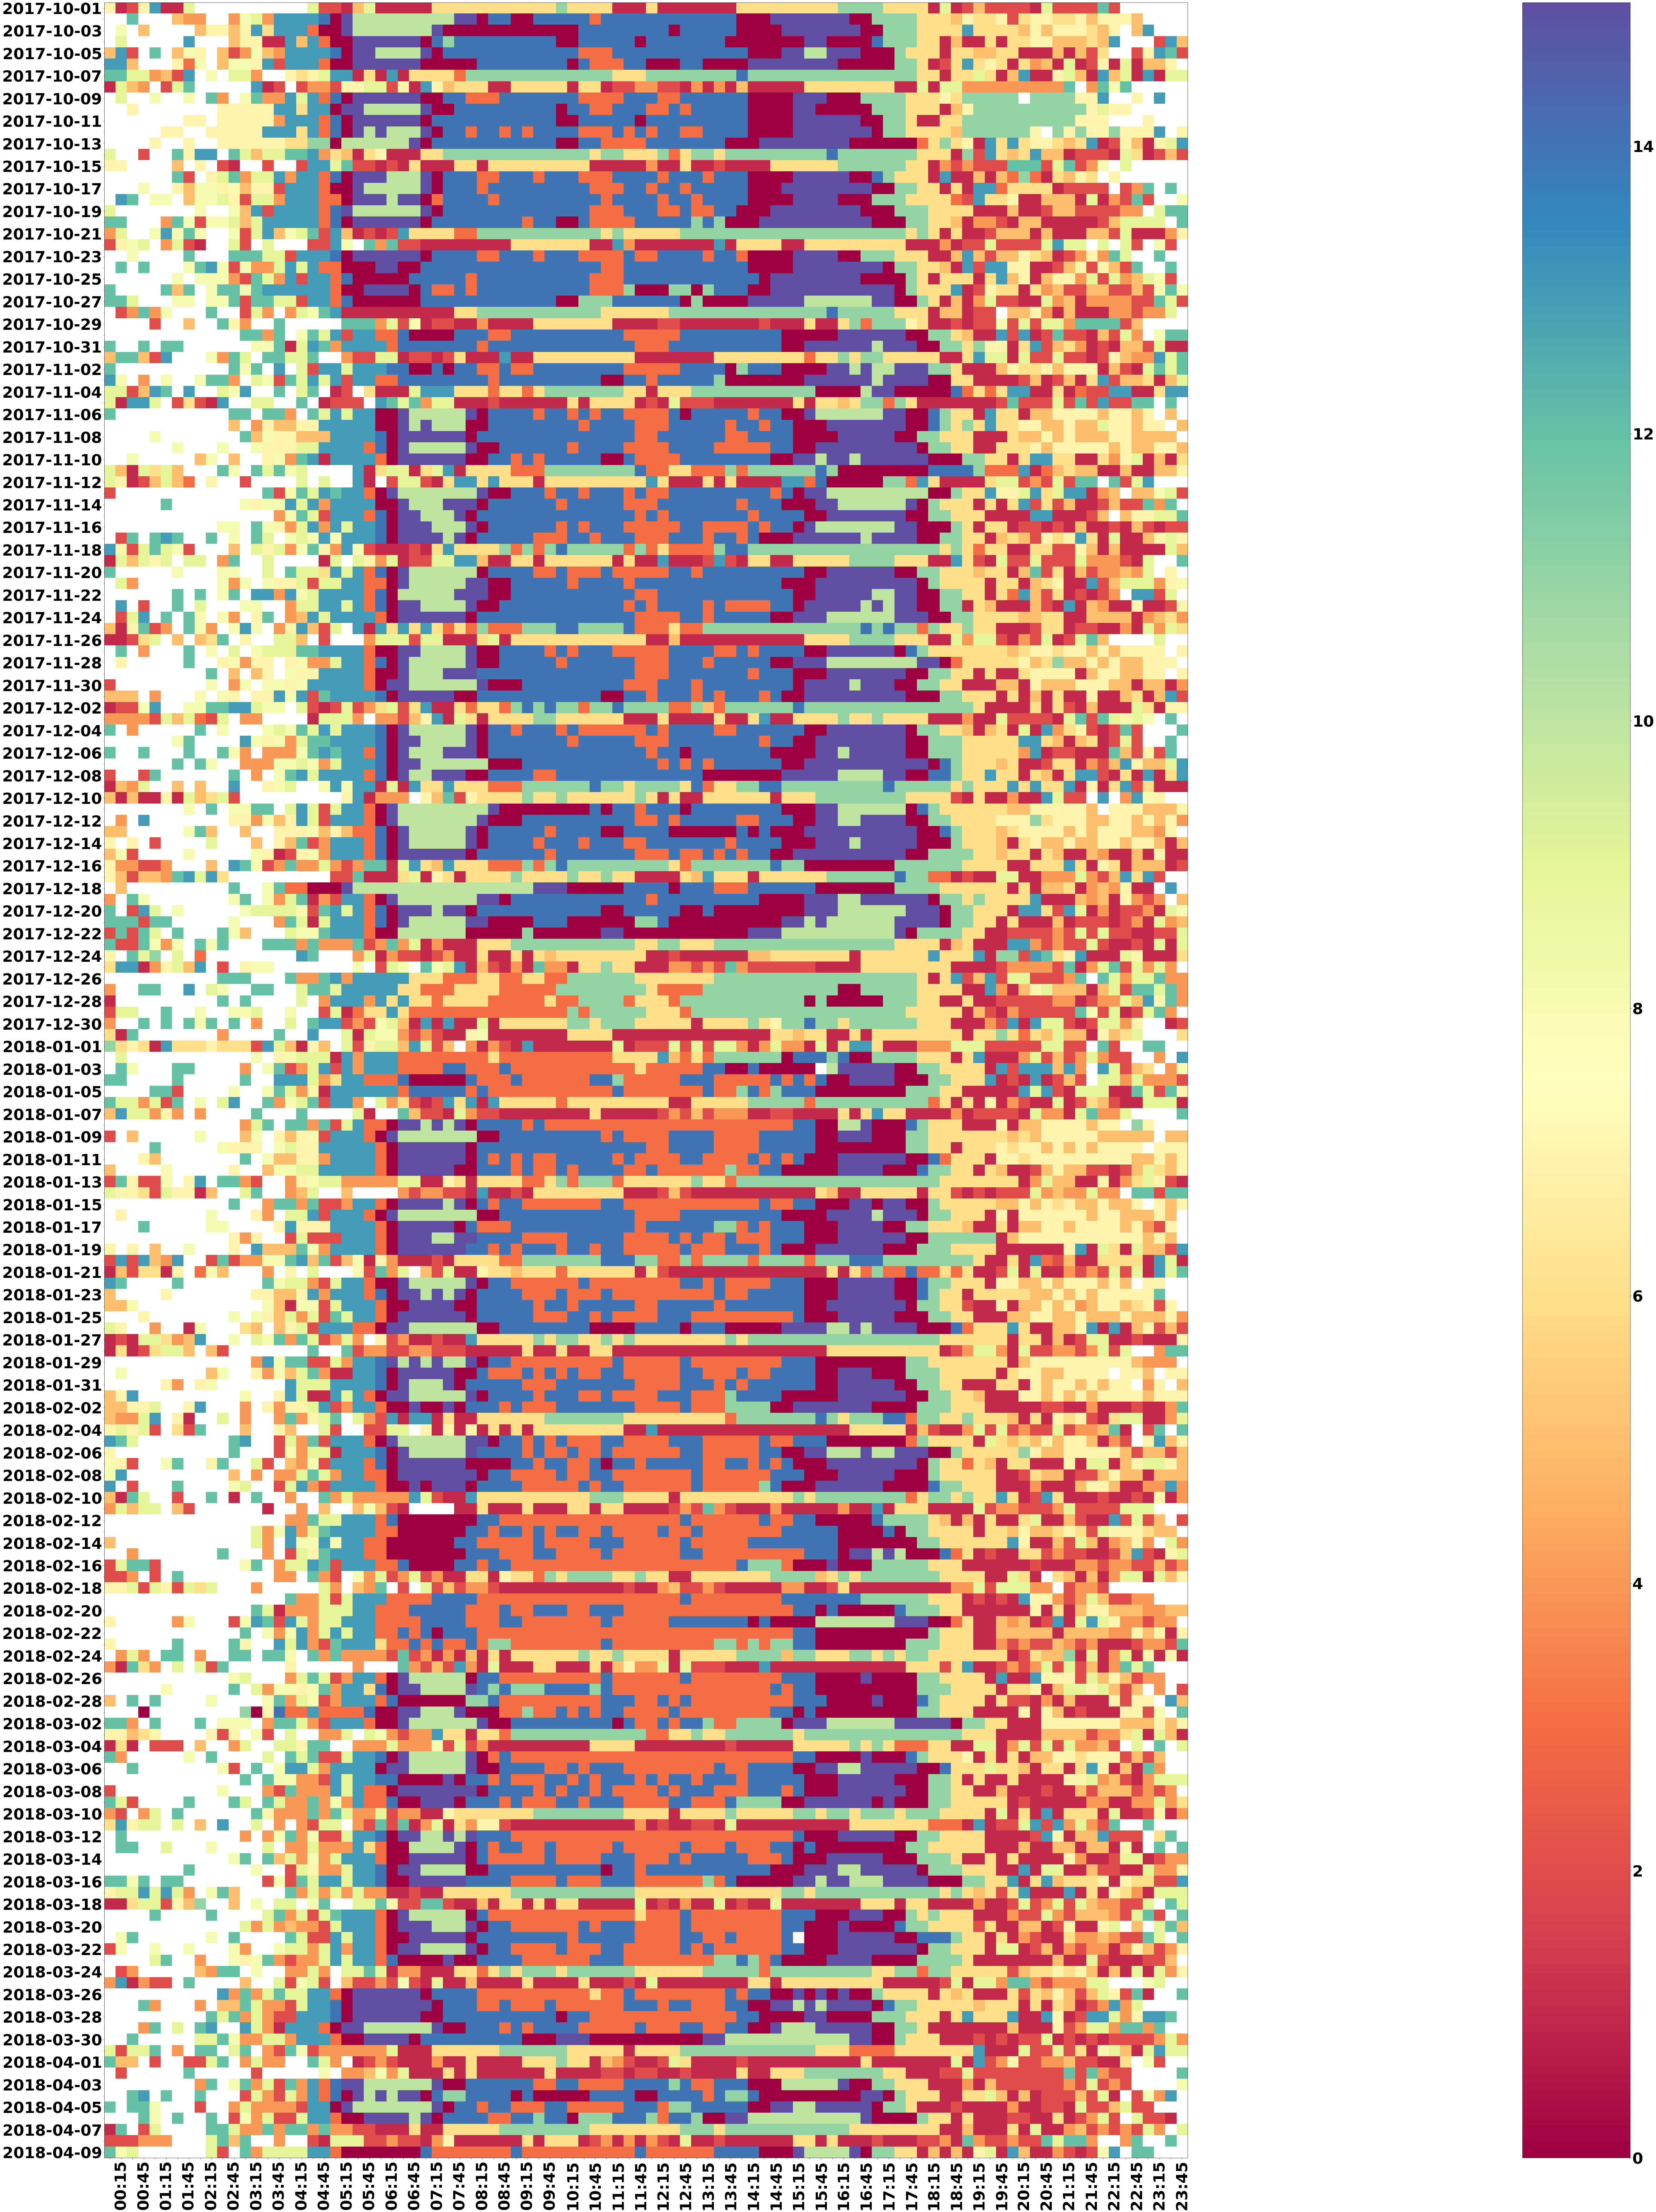

In [40]:
# 1. plotting the clusters over time

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


font = {'size'   : 50}

matplotlib.rc('font', **font)
temp_df = dfClusteredTripsPandas.pivot(index='the_date', columns='the_hour', values='prediction')
temp_df.sort_index(inplace=True) 
print(temp_df.head() )

fig = plt.figure(figsize = (300,100))
ax = fig.add_subplot(111)

cax = ax.matshow(temp_df.values, cmap="Spectral")
ax.xaxis.set_ticks_position('bottom') 

col_labels = temp_df.columns.values
x_labels = [(col_labels[i] if (i%2 == 1) else "") for i in range(len(col_labels))]
ax.set_xticks(range(len(col_labels)))
ax.set_xticklabels(x_labels, rotation=90) 

row_labels = temp_df.index.values
y_labels = [(row_labels[i]  if (i % 2 == 0 or i == len(row_labels) - 1) else "") for i in range(len(row_labels))] 
ax.set_yticks(range(len(row_labels)))
ax.set_yticklabels(y_labels)

fig.colorbar(cax)
plt.tight_layout()
plt.show()

In [47]:
# 2. plotting clusters' emitted average traffic distribution (the cluster centroid)
import pandas as pd

dfLinks = pd.read_csv(LINKS_FILEPATH)
communes = pd.Series(dfLinks["NOM_COM"].values,index=dfLinks["INSEE_COM"]).to_dict()
print(communes)
dfClusteredTripsPandasJoined = dfClusteredTripsPandas.rename(columns={str(key):value for (key,value) in communes.items()})

dfClusteredTripsPandasJoined.head()

{69112: 'Lentilly', 69086: "Fleurieux-sur-l'Arbresle", 69142: 'La Mulati�re', 69252: 'Tr�ves', 69277: 'Genas', 1049: 'La Boisse', 1418: 'Thil', 69072: 'Dardilly', 69010: "L'Arbresle", 69050: 'Ch�tillon', 69275: 'D�cines-Charpieu', 69271: 'Chassieu', 1376: 'Saint-Maurice-de-Beynost', 1043: 'Beynost', 69290: 'Saint-Priest', 69116: 'Limonest', 69282: 'Meyzieu', 69256: 'Vaulx-en-Velin', 69288: 'Saint-Laurent-de-Mure', 38449: 'Saint-Quentin-Fallavier', 42307: 'Tartaras', 69152: 'Pierre-B�nite', 69032: 'Bully', 69283: 'Mions', 1249: 'Miribel', 1275: 'Neyron', 69005: 'Amb�rieux', 1290: 'P�rouges', 69193: 'Saint-Cyr-sur-le-Rh�ne', 69297: 'Ternay', 38487: 'Seyssuel', 38087: 'Chasse-sur-Rh�ne', 69272: 'Communay', 38537: 'La Verpilli�re', 69270: 'Chaponnay', 69285: 'Pusignan', 1424: 'Tramoyes', 69208: 'Saint-Germain-Nuelles', 38544: 'Vienne', 69115: 'Limas', 1032: 'B�ligneux', 1027: 'Balan', 69294: 'S�r�zin-du-Rh�ne', 69280: 'Jons', 69163: 'Quincieux', 69286: 'Rillieux-la-Pape', 1248: 'Mionnay', 

,Bron,Caluire-et-Cuire,Champagne-au-Mont-d'Or,�cully,Francheville,La Mulati�re,Oullins,Pierre-B�nite,Saint-Fons,Sainte-Foy-l�s-Lyon,...,Lyon 4e Arrondissement,Lyon 5e Arrondissement,Lyon 6e Arrondissement,Lyon 7e Arrondissement,Lyon 8e Arrondissement,Lyon 9e Arrondissement,features,prediction,the_date,the_hour
0,74.231692,42.916859,79.934653,73.368350,37.916388,69.294602,59.285714,71.322121,73.301279,39.651558,...,29.561358,40.042265,31.795391,32.235552,30.067930,45.138773,"[29.5933147632312, 52.75593757068537, 26.83853...",13,2018-03-20,05:30
1,81.553903,48.025948,40.212644,57.216949,40.245098,75.040000,57.444444,75.754209,81.255319,44.432099,...,27.032609,37.770386,28.567273,35.985507,30.931624,69.905512,"[33.13636363636363, 47.26143790849673, 28.6685...",7,2017-10-04,03:15
2,81.187332,44.540541,68.152318,84.595469,36.684211,76.489627,68.411765,81.541599,87.863208,39.389610,...,32.430693,33.093023,25.184676,30.120059,32.789790,42.694581,"[27.35010940919037, 41.226436781609195, 29.242...",4,2017-10-28,22:30
3,64.488014,37.080174,63.342776,64.709077,35.996575,67.624161,68.019157,81.981992,77.838132,30.192308,...,26.863477,31.794393,28.526016,27.485447,28.807556,44.279696,"[22.55969331872946, 42.11018421967327, 25.7590...",6,2018-02-24,19:15
4,76.316344,42.585799,82.842857,67.489437,33.000000,81.526718,51.073593,69.185090,71.848601,39.962963,...,32.921875,29.937269,30.911661,28.300578,37.244094,41.944664,"[28.956521739130434, 50.55121293800539, 30.040...",13,2017-11-25,04:15


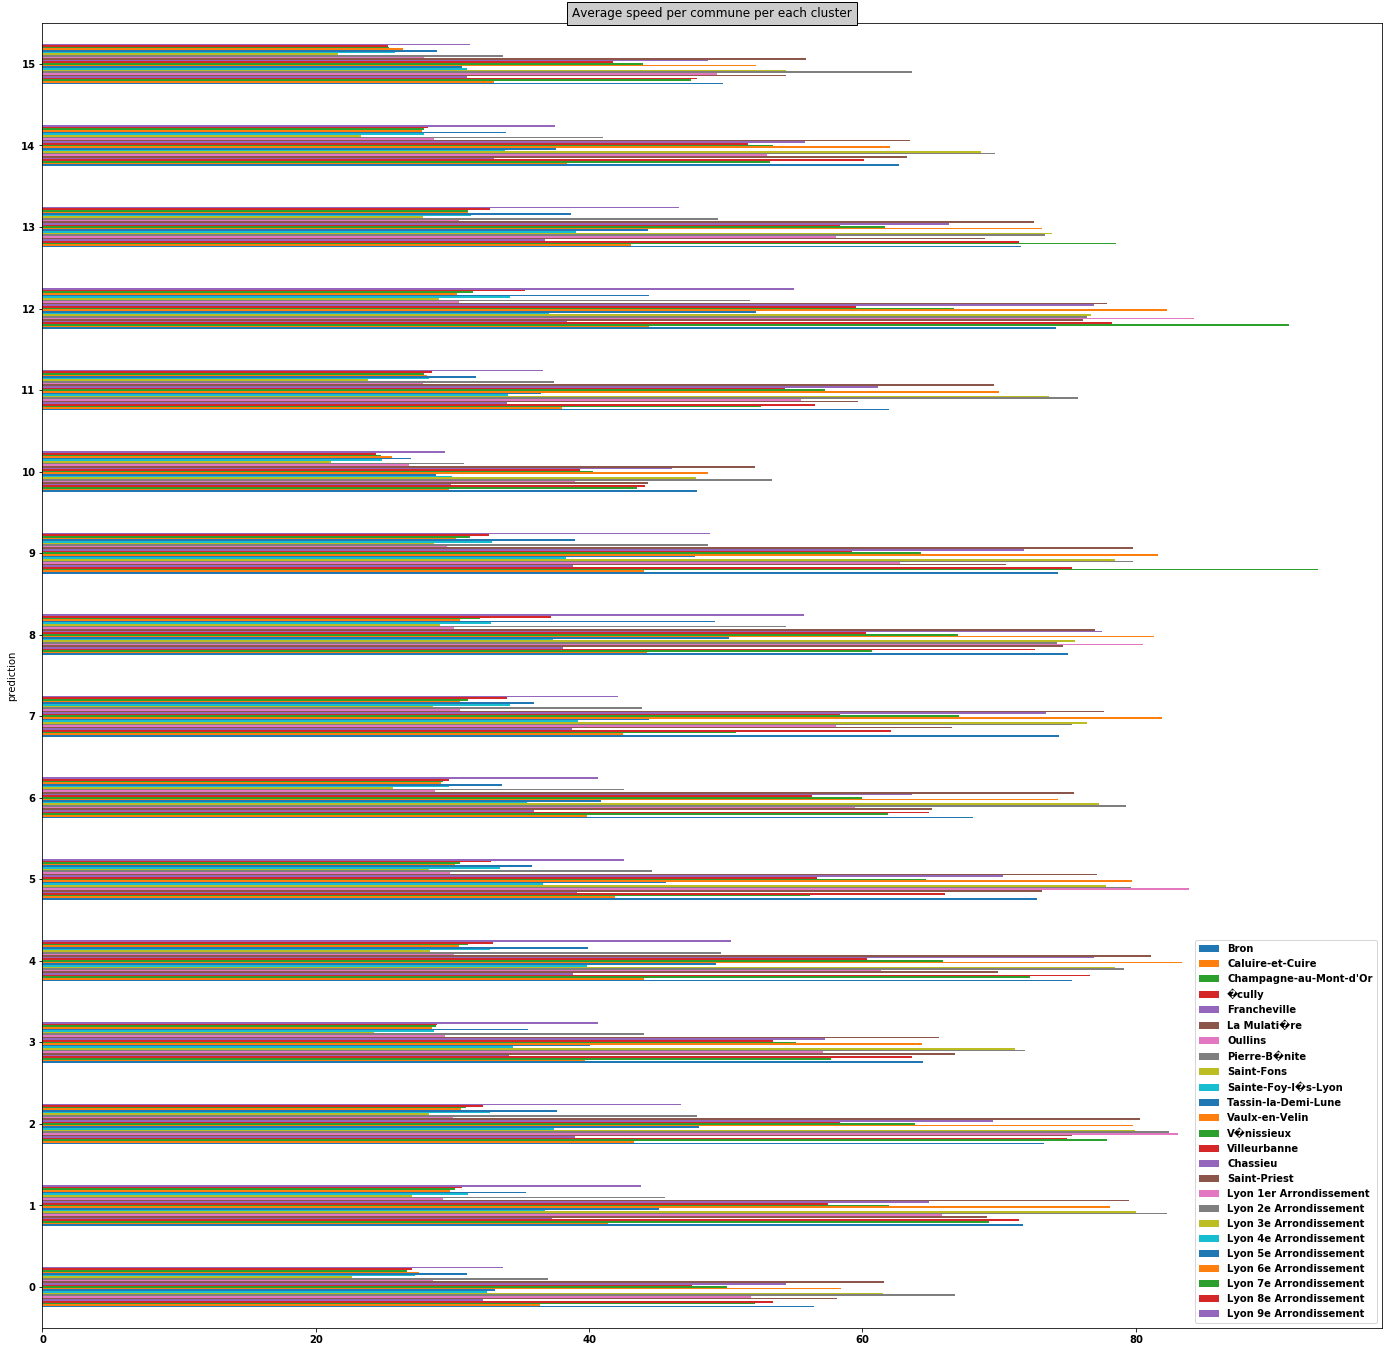

In [50]:
font = {'size'   : 10}

matplotlib.rc('font', **font)

dfClusteredTripsPandasJoined = dfClusteredTripsPandasJoined.groupby('prediction').mean()
dfClusteredTripsPandasJoined.head(20)
axes = dfClusteredTripsPandasJoined.plot.barh(rot=0, figsize = (24,24))
plt.title("Average speed per commune per each cluster", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

Multiple Clustering

In [ ]:
dfClusteredList = [dfClusteredTripsPandasJoined]
numClusters = [16]
for n in range(6, 35, 4):
    # Fitting the model to apply K-means
    with time_usage("Performing K-means clustering with " + str(n) + " clusters:"):
        kmeans_n = KMeans(k=n, seed=INITIAL_SEED)
        model_n = kmeans_n.fit(dfTripsFeatures.select('features'))
        dfClustered_n = model.transform(dfTripsFeatures)
        dfClusteredTripsPandas_n = dfClustered_n.toPandas()
        dfClusteredTripsPandas_n.to_csv(OUTPUT_FILENAME + '/../n_clusters/clustered_dataframe_' + str(n) + '.csv', index=False)
        dfClusteredList.append(dfClusteredTripsPandas_n)
        numClusters.append(n)

In [ ]:
sc.stop()